# Regression with BIWI head pose dataset

This is a more advanced example to show how to create custom datasets and do regression with images. Our task is to find the center of the head in each image. The data comes from the [BIWI head pose dataset](https://data.vision.ee.ethz.ch/cvl/gfanelli/head_pose/head_forest.html#db), thanks to Gabriele Fanelli et al. We have converted the images to jpeg format, so you should download the converted dataset from [this link](https://s3.amazonaws.com/fast-ai-imagelocal/biwi_head_pose.tgz).

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
from fastai.vision import *

### Download the dataset

In [5]:
path = untar_data(URLs.BIWI_HEAD_POSE)

In [6]:
path.ls() #each number means each person

[PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/18'),
 PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/11'),
 PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/10.obj'),
 PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/19'),
 PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/17.obj'),
 PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/11.obj'),
 PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/22.obj'),
 PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/07'),
 PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/16.obj'),
 PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/04.obj'),
 PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/13.obj'),
 PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/04'),
 PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/02.obj'),
 PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/06.obj'),
 PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/05.obj'),
 PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/io_sam

In [7]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6); cal

array([[517.679,   0.   , 320.   ],
       [  0.   , 517.679, 240.5  ],
       [  0.   ,   0.   ,   1.   ]])

In [8]:
fname = '09/frame_00667_rgb.jpg'

In [9]:
def img2txt_name(f): return path/f'{str(f)[:-7]}pose.txt'

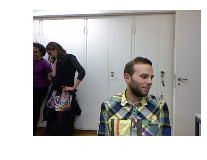

In [10]:
img = open_image(path/fname)
img.show()

In [11]:
ctr = np.genfromtxt(img2txt_name(fname), skip_header=3); ctr

array([187.332 ,  40.3892, 893.135 ])

In [12]:
def convert_biwi(coords):
    c1 = coords[0] * cal[0][0]/coords[2] + cal[0][2]
    c2 = coords[1] * cal[1][1]/coords[2] + cal[1][2]
    return tensor([c2,c1])

def get_ctr(f):
    ctr = np.genfromtxt(img2txt_name(f), skip_header=3)
    return convert_biwi(ctr)

def get_ip(img,pts): return ImagePoints(FlowField(img.size, pts), scale=True)

In [13]:
get_ctr(fname) #coordinate

tensor([263.9104, 428.5814])

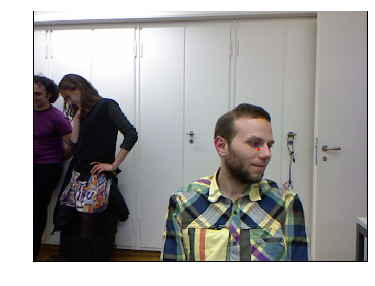

In [14]:
ctr = get_ctr(fname)
img.show(y=get_ip(img, ctr), figsize=(6, 6))

### Creating a dataset

In [16]:
data = (PointsItemList.from_folder(path)
       .split_by_valid_func(lambda o: o.parent.name=='13')
       .label_from_func(get_ctr)
       .transform(get_transforms(), size= (120, 160), tfm_y = True) 
       .databunch()
       .normalize(imagenet_stats))

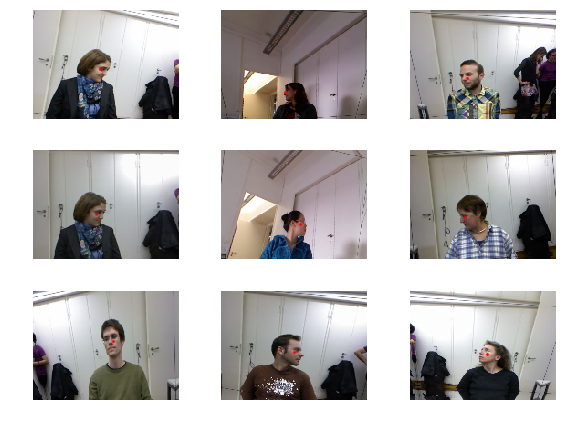

In [17]:
data.show_batch(3, figsize=(8,6))

### Training

In [18]:
learn = cnn_learner(data, models.resnet34)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


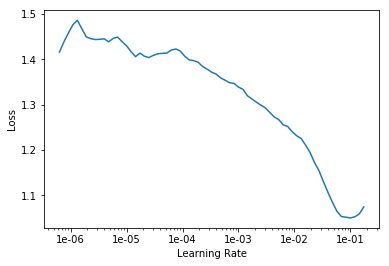

In [19]:
lr_find(learn)
learn.recorder.plot()

In [26]:
lr = 2e-2; lr

0.02

In [28]:
learn.fit_one_cycle(5,slice(lr))

epoch,train_loss,valid_loss,time
0,0.049573,0.004557,01:13
1,0.017457,0.004553,01:12
2,0.008613,0.001336,01:12
3,0.005175,0.003580,01:12
4,0.003951,0.000694,01:12


In [29]:
learn.save('stage-1')

In [30]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (15193 items)
x: PointsItemList
Image (3, 120, 160),Image (3, 120, 160),Image (3, 120, 160),Image (3, 120, 160),Image (3, 120, 160)
y: PointsLabelList
ImagePoints (120, 160),ImagePoints (120, 160),ImagePoints (120, 160),ImagePoints (120, 160),ImagePoints (120, 160)
Path: /home/jupyter/.fastai/data/biwi_head_pose;

Valid: LabelList (485 items)
x: PointsItemList
Image (3, 120, 160),Image (3, 120, 160),Image (3, 120, 160),Image (3, 120, 160),Image (3, 120, 160)
y: PointsLabelList
ImagePoints (120, 160),ImagePoints (120, 160),ImagePoints (120, 160),ImagePoints (120, 160),ImagePoints (120, 160)
Path: /home/jupyter/.fastai/data/biwi_head_pose;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dila

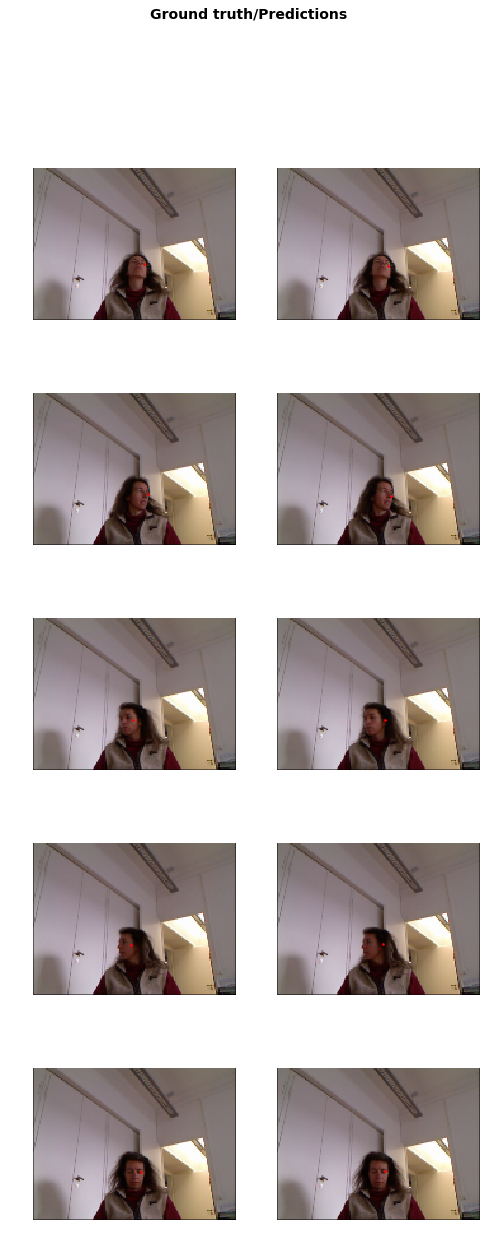

In [31]:
learn.show_results(3)

### The End